In [1]:
import matplotlib as mlt
import matplotlib.pyplot as plt

import itertools

import numpy as np
import cv2
from scripts.utils import *

%matplotlib inline
mlt.rcParams['figure.figsize'] = (15,8)

# Edge detection

## 1 First order gradient : Sobel filters

What is an edge ? In an image, an edge is a rapid change of intensity. So we need to compute the first order gradient of the image intensity function and detect it's peaks (gradient is maximal where the change is most abrupt). The classical discrete differentiation operators are known as [Sobel or Sobel-Feldman operators](https://en.wikipedia.org/wiki/Sobel_operator). For a given pixel the differentiatiation can be seen as the difference of intensities between its 1D neighbors : 

$\begin{bmatrix}
-1 & 0 & +1
\end{bmatrix}$ or $\begin{bmatrix}
-1\\
0\\
+1\end{bmatrix}$ 

We can consider the opposites of these vectors which calculate the difference in the other direction). The Sobel fitlers are a convolution between a gaussian smoothing operator (which adds some resistance to noise) and one of these differentiation operators : 

* Sobel X : $\begin{bmatrix}
1\\
2\\
1
\end{bmatrix} * \begin{bmatrix}
-1 & 0 & +1
\end{bmatrix} = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}$
* Sobel Y : $\begin{bmatrix}
-1\\
0\\
+1
\end{bmatrix} * \begin{bmatrix}
1 & 2 & 1
\end{bmatrix} = \begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}$.

We will use a sudoku photo that has clear vertical and horizontal lines to illustrate this section. Image taken from [here](https://blog.hbldh.se/2016/2/extracting-sudokus-from-images-using-scikit-image/).

In [2]:
img_gray = cv2.imread('data/sudoku.jpg', 0)

Now we can convolve the image with a hand made sobel filter or we can use <code>cv2.Sobel()</code>. An important thing to notice here, as explained [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html), is that applying a sobel filter may result in negative values for negative slopes so if we stick to working with <code>np.uint8</code> datatype, these values will just be put to zero and we will miss out the information. Thus, we need to use some higher forms of datatype, e.g. <code>np.float64</code>, and then take the absolute value of the matrix to be able to convert it back to <code>np.uint8</code> without losing edge information.

In [3]:
# Option 1
sobel_kernel_x = np.array([[-1., 0., 1.],[-2., 0., 2.], [-1., 0., 1.]])
sobel_x = cv2.filter2D(img_gray, cv2.CV_64F, sobel_kernel_x)
sobel_x_rescaled = cv2.convertScaleAbs(sobel_x) # Converts back to 8bit uint

sobel_kernel_y = np.array([[-1., -2., -1.],[0., 0., 0.], [1., 2., 1.]])
sobel_y = cv2.filter2D(img_gray, cv2.CV_64F, sobel_kernel_y)
sobel_y_rescaled = cv2.convertScaleAbs(sobel_y) # Converts back to 8bit uint

# Option 2
# sobel_x = cv2.Sobel(img_gray_smooth, cv2.CV_64F, 1, 0, ksize=3)
# sobel_x_rescaled = cv2.convertScaleAbs(sobel_x)
# sobel_y = cv2.Sobel(img_gray_smooth, cv2.CV_64F, 0, 1, ksize=3)
# sobel_y_rescaled = cv2.convertScaleAbs(sobel_y)

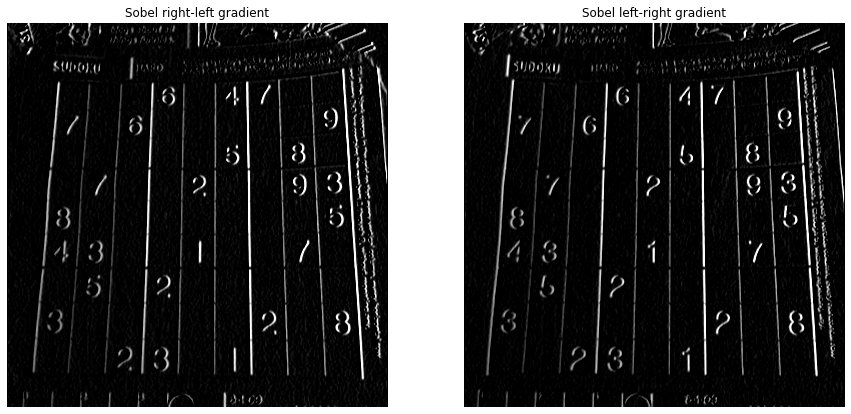

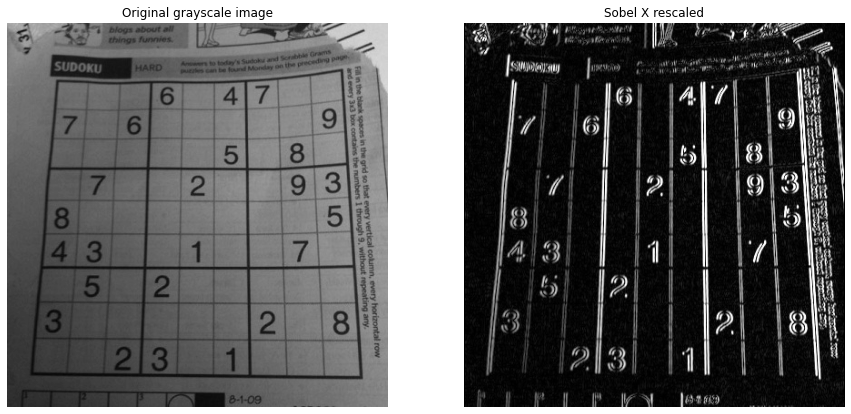

In [4]:
plot_2_images(sobel_x, 
              -sobel_x, 
              "gray", 
              'Sobel right-left gradient',
              'Sobel left-right gradient')

plot_2_images(img_gray, 
              sobel_x_rescaled, 
              "gray", 
              'Original grayscale image',
              'Sobel X rescaled')

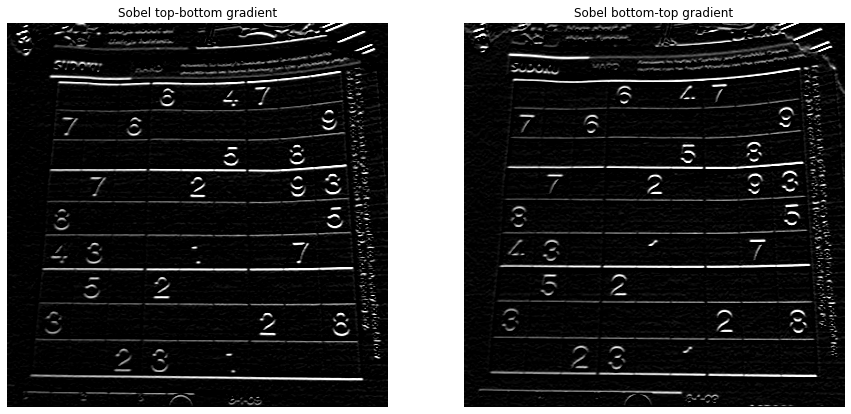

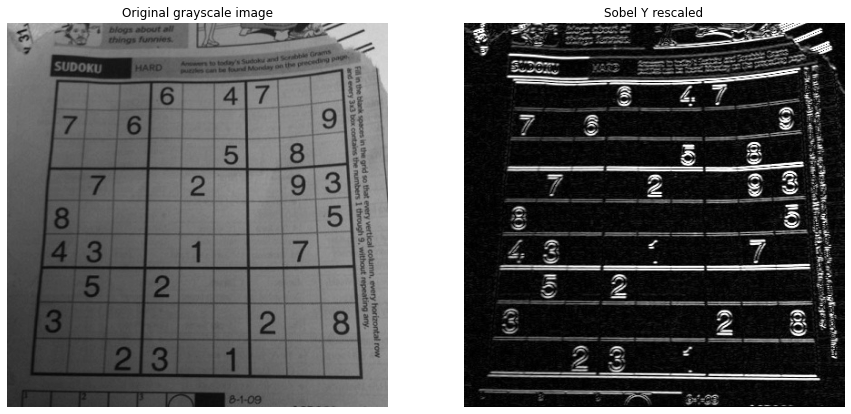

In [5]:
plot_2_images(sobel_y, 
              -sobel_y, 
              "gray", 
              'Sobel top-bottom gradient',
              'Sobel bottom-top gradient')

plot_2_images(img_gray, 
              sobel_y_rescaled, 
              "gray", 
              'Original grayscale image',
              'Sobel Y rescaled')

How can we combine these two results to obtain a general edge detection ? To approximate the gradient at each point we use the following formula (with $I$ being our original image): $G = \sqrt{(SobelX*I)^2 + (SobelY*I)^2}$ or in a more simpler approximation $G = |SobelX*I| + |SobelY*I|$ 

In [6]:
# Recall that addWeighted handles internally all the rescaling when values fall outside of [0, 255]
# In sobel_x_rescaled, sobel_y_rescaled the absolute value is already taken
sobel_xy = cv2.addWeighted(sobel_x_rescaled, 1, sobel_y_rescaled, 1, 0, None)

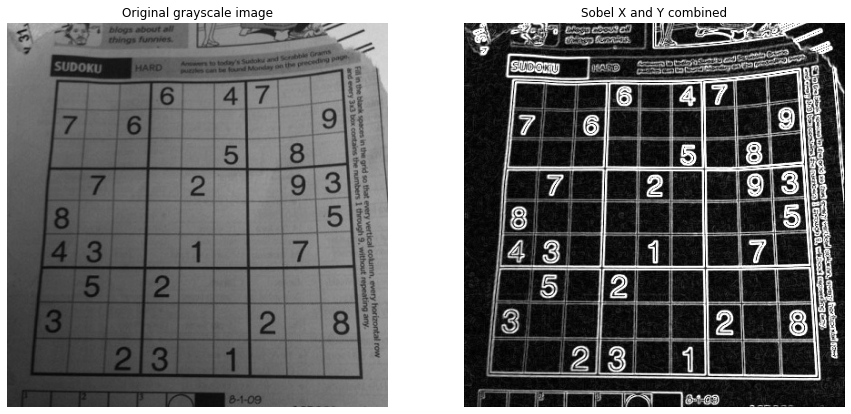

In [7]:
plot_2_images(img_gray, 
              sobel_xy, 
              "gray", 
              'Original grayscale image',
              'Sobel X and Y combined')

### 3.2 Second order gradient : Laplacian operator

To get information about very low and very high gradients, instead of just the peaks of the first derivative, we can look at the second order derivative (which crosses 0 when the first derivative peaks). We do this by considering the [Laplacian operator](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html) ([documentation](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6)) : 

$\frac{\delta^2f}{\delta x^2}+\frac{\delta^2f}{\delta y^2}^2$

It allows us to consider gradients in both directions simultaneously. In order to avoid being polluted by the high frequency noise in the image, before applying the gradient filter we will apply a smoothing filter.

In [8]:
# Smooth image to remove potential high freq noise
img_gray_smooth = cv2.GaussianBlur(img_gray,(3, 3), 0.1)
# The ksize argument is the "Aperture size used to compute the second-derivative filters."
laplacian = cv2.Laplacian(img_gray_smooth, cv2.CV_64F, None, ksize = 3)
# Take absolute value to inclue information about negative values
laplacian_rescaled = cv2.convertScaleAbs(laplacian) # Converts back to 8bit uint

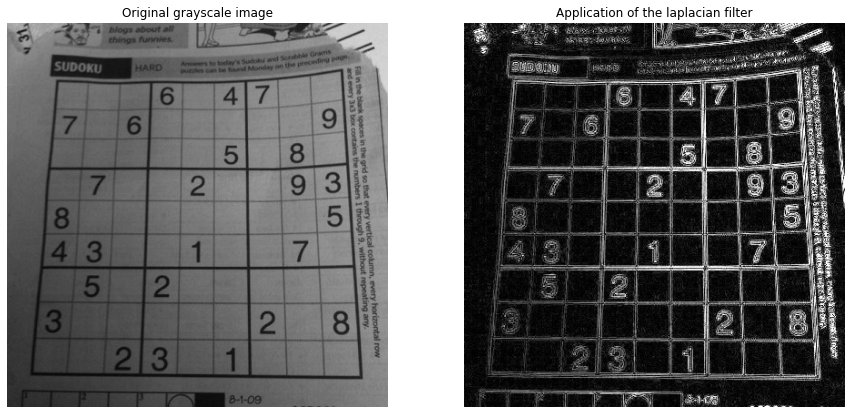

In [9]:
plot_2_images(img_gray, 
              laplacian_rescaled, 
              "gray", 
              'Original grayscale image',
              'Application of the laplacian filter')

### 3.3 Canny edge detection

When we want to detect edges we want to have a single pixel line representing the edge, no a thick blurry line like we obtained before. The canny edge detection is a popular edge detection algorithm developped in 1986 (see [documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html)). It basically takes what we did with the gradient detection (*blurring* and *gradient calculation*) and add two more steps (*non-max suppression* and *hysteresis thresholding*) to obtain the desired result in the end. So the steps are :

Let us try this with an image of the face of John Canny himself from [here](https://people.eecs.berkeley.edu/~jfc/).

In [10]:
canny = cv2.imread('data/canny.jpg', 0)

* 1. **Noise reduction** using a low pass filter, classically a Gaussian blur

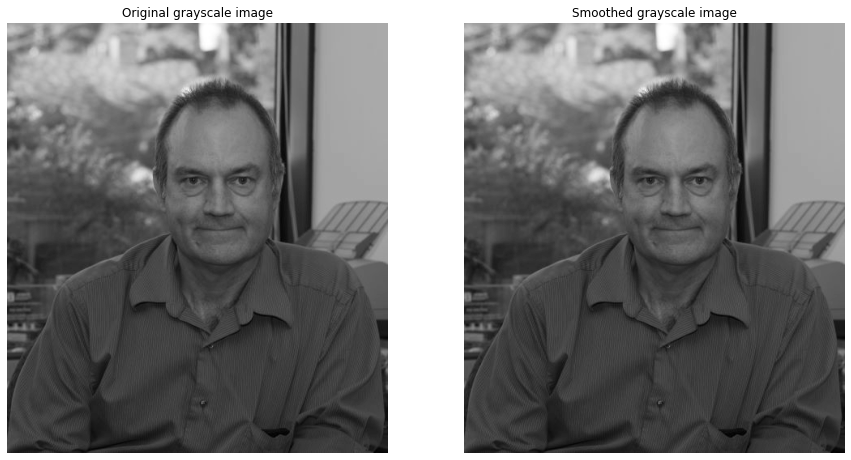

In [11]:
def smooth_image(source_image):
    """ 
        Input : source grayscale image
        First step of the algorithm : smooth image to reduce noise.
        We do this by applying a gaussian blur, given its parameters.
        Output : blurred source grayscale image
    """
    return cv2.GaussianBlur(source_image, (5, 5), .1)
    
smoothed_image = smooth_image(canny)
plot_2_images(canny, 
              smoothed_image, 
              "gray", 
              'Original grayscale image',
              'Smoothed grayscale image')

* 2. **Intensity gradient calculation**, can be obtained by passing the Sobel X and Sobel Y filters on the image and combining the results as we did in 3.1

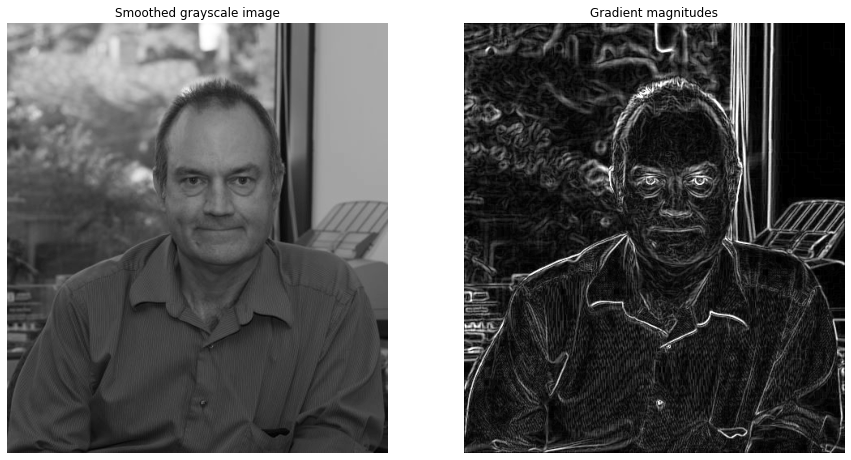

In [12]:
def calculate_intensity_gradient(smoothed_image):
    """
        Input : blurred source grayscale image
        Second step of the algorithm : calculate intensity gradient magnitude and direction
        We do this by calculating sobel X and sobel Y :
            - The magnitude is given by the approximation G_mag = |G_x|+|G_y|
            - The direction is given by G_dir = arctan((G_x) / (G_y)))
        Output: gradient magnitude and direction matrices
    """
        
    # Apply sobel filters in both directions x and y
    G_x = cv2.Sobel(smoothed_image, cv2.CV_64F, dx = 1, dy = 0, ksize = 3)
    G_y = cv2.Sobel(smoothed_image, cv2.CV_64F, dx = 0, dy = 1, ksize = 3)
        
    # Calculate gradient magnitude G_mag = |G_x|+|G_y|
    G_mag = cv2.addWeighted(cv2.convertScaleAbs(G_x), 1, cv2.convertScaleAbs(G_y), 1, 0, None)
        
    # Calculate gradient direction G_dir = arctan((sobel_y*I) / (sobel_x*I)))
    # arctan2 returns between [pi, -pi]
    G_dir = np.arctan2(G_y, G_x)
        
    return G_mag, G_dir
    
G_mag, G_dir = calculate_intensity_gradient(smoothed_image)
plot_2_images(smoothed_image, 
              G_mag, 
              "gray", 
              'Smoothed grayscale image',
              'Gradient magnitudes')

* 3. **Non-max suppression** is used to remove unwanted pixels that do not represent the edge to get rid of the thickness. For each pixel we check if it's intensity is the maximum in a given neighborhood around it, if yes we keep it, if no we discard it.

We have eight possible directions on a 3x3 grid of pixels, and we can delimit those directions by separating a circle in eight regions: for each of the eight $\theta$ angles $(0, \frac{\pi}{4}, -\frac{\pi}{4}, \frac{\pi}{2}, -\frac{\pi}{2}, \pi, -\pi)$ we consider the direction to be delimited by $[\theta + \frac{\pi}{8}, \theta - \frac{\pi}{8}]$

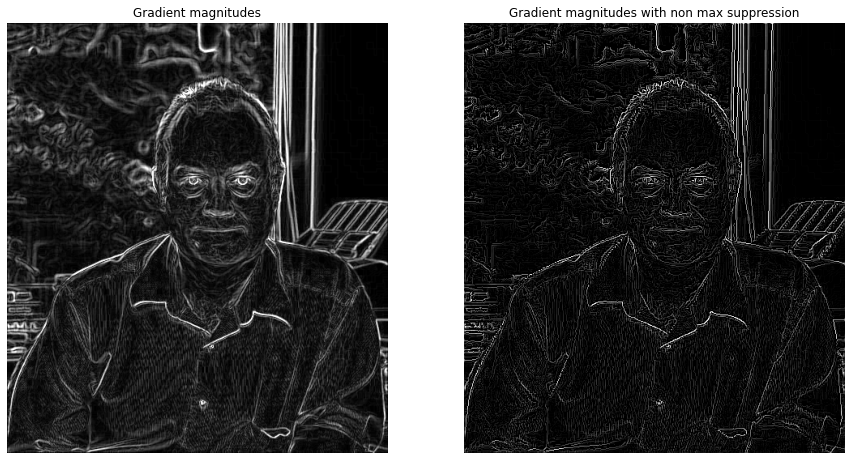

In [20]:
def non_max_suppression(G_mag, G_dir):
    """
        Input : gradient magnitudes and direction
        Third step of the algorithm : edge thinning on the gradient magnitude matrice
        For each pixel (except the border ones):
            - Look at its two neighbors in the direction of the gradient. We need to consider a range
             of angles that will define a direction for picking the neighbot pixels.
             - If its magnitude is maximal leave it unchanged, if not set it to 0
        Output : modified gradient magnitude matrix
    """
        
    h, w = G_mag.shape
    G_mag_nmx = G_mag.copy()
        
    for i in range(1, h - 1):
        for j in range(1, w - 1):
                
            # Get current pixel gradient direction (between pi and -pi)
            # We can consider the abs because for theta and -theta we will check the same neighbors
            grad_direction = np.abs(G_dir[i, j])
                
            # Left to right
            if 0 <= grad_direction < (0. + np.pi/8) or (np.pi - np.pi/8) < grad_direction <= np.pi:
                n1 = G_mag_nmx[i, j-1]
                n2 = G_mag_nmx[i, j+1]
                
            # Bottom left to top right
            elif (np.pi/4 - np.pi/8) <= grad_direction < (np.pi/4 + np.pi/8):
                n1 = G_mag_nmx[i+1, j-1]
                n2 = G_mag_nmx[i-1, j+1]
                
            # Bottom to top
            elif (np.pi/2 - np.pi/8) <= grad_direction < (np.pi/2 + np.pi/8):
                n1 = G_mag_nmx[i+1, j]
                n2 = G_mag_nmx[i-1, j]
                
            # Bottom right to top left
            elif (3*np.pi/4 - np.pi/8) <= grad_direction < (3*np.pi/4 + np.pi/8):
                n1 = G_mag_nmx[i+1, j+1]
                n2 = G_mag_nmx[i-1, j-1]
                
            if n1 >= G_mag_nmx[i, j] or  n2 >= G_mag_nmx[i, j]:
                G_mag_nmx[i, j] = 0
        
    return G_mag_nmx
    
G_mag_nmx = non_max_suppression(G_mag, G_dir)
plot_2_images(G_mag, 
              G_mag_nmx, 
              "gray", 
              'Gradient magnitudes',
              'Gradient magnitudes with non max suppression')

* 4. **Hysteresis thresholding** is used to keep the "real" strong edges of the image by using a gradient intensity min and max thresholds. Below min we discard, above max we keep, in between we take a decision : if the edge is connected to one above the max value we keep it, if not we discard it. The choice of the min/max values will greatly influence the outcome of the algorithm.

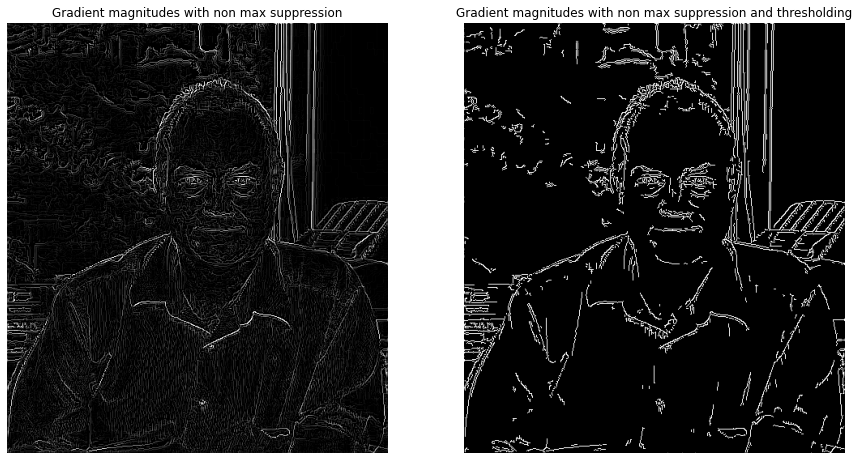

In [21]:
def hysteresis_thresholding(G_mag_nmx, minVal, maxVal):
    """
        Input : gradient intensity matrix with non max suppression applied
        Final step of the algorithm to keep only strong edges (and edges connected to strong ones)
        Given min and max values of thresholding:
            - If an edge falls under the min, we discard it (setting it to 0)
            - If an edge falls above the max, we keep it (setting it to 255)
            - If an edge falls in between :
                - If it is connected to a strong edge, we keep it (setting it to 255)
                - Else we discard it
        Output: Thresholded gradient intensity matrix with non max suppression applied
    """
    
    h, w = G_mag_nmx.shape
    G_thresh = G_mag_nmx.copy()
    G_thresh[G_thresh < minVal] = 0
    G_thresh[G_thresh > maxVal] = 255
    
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if G_thresh[i, j] in [0, 255]:
                continue
            else:
                neighbors = np.array([G_thresh[i + offset[0], j + offset[1]] 
                             for offset in list(itertools.product([-1, 1, 0],[-1, 1, 0]))
                             if (offset[0]!=0 or offset[1]!=0)])
                G_thresh[i, j] = 0 if np.all(neighbors != 255) else 255
    return G_thresh

G_thresh = hysteresis_thresholding(G_mag_nmx, 50, 100)
plot_2_images(G_mag_nmx, 
              G_thresh, 
              "gray", 
              'Gradient magnitudes with non max suppression',
              'Gradient magnitudes with non max suppression and thresholding')

Let us compare the result to the output of the opencv method <code>cv2.Canny</code>

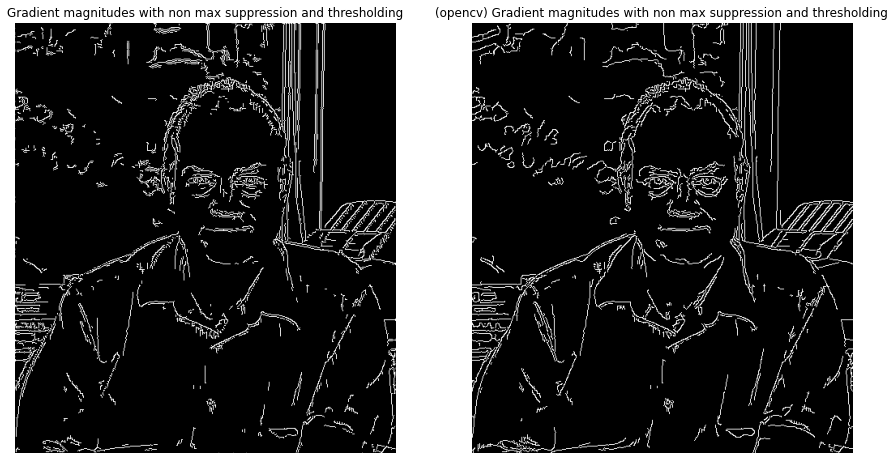

In [22]:
opencv_result = cv2.Canny(canny,50,100)
plot_2_images(G_thresh, 
              opencv_result, 
              "gray", 
              'Gradient magnitudes with non max suppression and thresholding',
              '(opencv) Gradient magnitudes with non max suppression and thresholding')